# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름: 
- 학번: 
- 제출일: 

---

## 📋 과제 목표

**가격 변화 방향을 예측하는 딥러닝 모델과 트레이딩 전략을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 가격 상승(1) / 하락(0)을 예측하는 2-class 분류 모델
   - PyTorch 사용
   - 실습에서 배운 피처 엔지니어링 활용

2. **트레이딩 전략 개발** (핵심)
   - 예측 확률을 활용한 포지션 크기 조절
   - 예: 상승 확률 60% → 자본의 60% 투자
   - 또는 자신만의 전략 개발

3. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (60%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 & 전략 설계** (30%)
  - 모델 아키텍처 선택 이유
  - 트레이딩 전략 논리성
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

실습 노트북과 동일한 데이터 및 피처를 사용합니다!

In [1]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/juho127/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 실습 노트북과 동일한 유틸리티 함수 사용
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    device
)

# 영문 폰트 설정 (시각화용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

Using device: cpu
✅ 라이브러리 로딩 완료!
Using device: cpu


In [3]:
# 데이터 로딩 및 피처 생성 (실습과 동일)
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
btc_features = create_features(btc_data, lookback_days=10)

print(f"\n데이터 shape: {btc_features.shape}")
print(f"생성된 특성 수: {len([c for c in btc_features.columns if c not in ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")
print(f"\n주요 특성:")
print("- 이동평균 (MA_5, MA_10, MA_20, MA_50)")
print("- 변동성 (Volatility_5, Volatility_10, Volatility_20)")
print("- RSI, MACD")
print("- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)")

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-12-21


[*********************100%***********************]  1 of 1 completed

다운로드 완료: 2181 행

데이터 shape: (2181, 35)
생성된 특성 수: 29

주요 특성:
- 이동평균 (MA_5, MA_10, MA_20, MA_50)
- 변동성 (Volatility_5, Volatility_10, Volatility_20)
- RSI, MACD
- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)


In [4]:
# 데이터 분할 및 정규화 (실습과 동일)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features, test_size=0.2, validation_size=0.1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")

학습 데이터: 1492 샘플
검증 데이터: 213 샘플
테스트 데이터: 427 샘플
학습: 1492, 검증: 213, 테스트: 427


In [5]:
# 시퀀스 데이터 생성 (딥러닝용)
sequence_length = 30

def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print(f"시퀀스 데이터 shape: {X_train_seq.shape}")
print(f"  - 샘플 수: {X_train_seq.shape[0]}")
print(f"  - 시퀀스 길이: {X_train_seq.shape[1]}")
print(f"  - 특성 수: {X_train_seq.shape[2]}")

시퀀스 데이터 shape: (1462, 30, 29)
  - 샘플 수: 1462
  - 시퀀스 길이: 30
  - 특성 수: 29


In [6]:
# DataLoader 생성
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.FloatTensor(y_train_seq)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.FloatTensor(y_val_seq)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 생성 완료!")

✅ DataLoader 생성 완료!


## 2. 예제: LSTM 모델 + 확률 기반 포지션 조절 전략

이 예제는 2가지 핵심 요소로 구성됩니다:

1. **예측 모델**: 가격 상승/하락을 예측하고 확률 제공
2. **트레이딩 전략**: 예측 확률에 따라 투자 비율 조절

### 전략 예시
- 상승 확률 90% → 자본의 90% 투자
- 상승 확률 60% → 자본의 60% 투자
- 상승 확률 40% → 투자하지 않음 (현금 보유)

In [7]:
# 예제 모델: LSTM 기반 2-class 분류기
class ExampleLSTMModel(nn.Module):
    """
    예제: LSTM 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(ExampleLSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        self.lstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)
        
        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])
        lstm_out = self.bn2(lstm_out)
        
        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.dropout3(out)
        
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out

# 예제 모델 생성
example_model = ExampleLSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(example_model)
print(f"\nTotal parameters: {sum(p.numel() for p in example_model.parameters()):,}")

예제 모델 구조:
ExampleLSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37,601


In [8]:
# 학습 함수 (제공됨)
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted.squeeze() == batch_y).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted.squeeze() == batch_y).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

print("✅ 학습 함수 준비 완료!")

✅ 학습 함수 준비 완료!


In [9]:
# 예제 모델 학습
print("예제 모델 학습 시작...")
example_history = train_model(
    model=example_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)
print("\n✅ 예제 모델 학습 완료!")

예제 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6763, Val Loss: 0.6946, Train Acc: 0.5705, Val Acc: 0.4973
Early stopping at epoch 17

✅ 예제 모델 학습 완료!


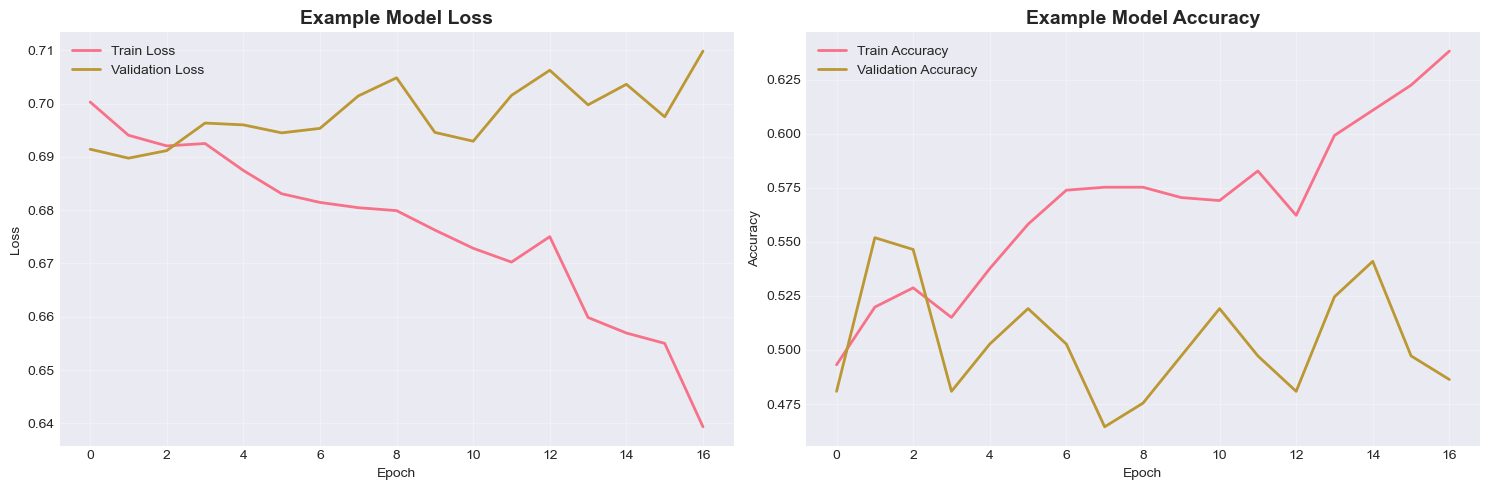

In [10]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(example_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(example_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Example Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(example_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(example_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("Example Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 트레이딩 전략: 확률 기반 포지션 조절

예측 확률에 따라 투자 비율을 조절하는 전략입니다.

In [11]:
# 예측 함수 (확률 포함)
def predict_with_probability(model, data_loader):
    """
    모델 예측 및 확률 반환
    """
    model.eval()
    predictions_prob = []
    
    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_prob.append(outputs.cpu().numpy())
    
    predictions_prob = np.vstack(predictions_prob).flatten()
    predictions = (predictions_prob > 0.5).astype(int)
    
    return predictions_prob, predictions

# 예제 모델 예측
example_prob, example_pred = predict_with_probability(example_model, test_loader)

print(f"예측 완료!")
print(f"예측 수: {len(example_pred)}")
print(f"상승 예측: {np.sum(example_pred == 1)}개")
print(f"하락 예측: {np.sum(example_pred == 0)}개")
print(f"\n평균 상승 확률: {example_prob.mean():.2%}")

예측 완료!
예측 수: 397
상승 예측: 76개
하락 예측: 321개

평균 상승 확률: 44.27%


In [12]:
# 확률 기반 트레이딩 전략
def simulate_probability_trading(predictions_prob, actual_prices, dates, 
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.5, position_scaling=True):
    """
    확률 기반 트레이딩 시뮬레이션
    
    Parameters:
    -----------
    predictions_prob : array
        상승 확률 (0~1)
    actual_prices : array
        실제 가격
    dates : array
        날짜
    initial_capital : float
        초기 자본
    transaction_fee : float
        거래 수수료
    threshold : float
        매수 결정 임계값 (기본 0.5)
    position_scaling : bool
        True: 확률에 비례하여 투자 비율 조절
        False: 임계값 초과 시 전액 투자
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []
    
    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]
        
        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)
        
        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL_ALL',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue
        
        # 투자 비율 결정
        if position_scaling:
            # 확률 기반 포지션 조절
            if prob > threshold:
                # 확률에 비례하여 투자 (예: 70% 확률 → 70% 투자)
                invest_ratio = prob
            else:
                # 임계값 미만이면 매도 또는 관망
                invest_ratio = 0
        else:
            # 단순 전략: 임계값 초과 시 전액 투자
            invest_ratio = 1.0 if prob > threshold else 0.0
        
        # 현재 포지션 비율
        current_position_ratio = (btc_holdings * current_price) / portfolio_value if portfolio_value > 0 else 0
        
        # 포지션 조정
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price
        
        if target_btc_value > current_btc_value:  # 매수 필요
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash:
                buy_cash = cash
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                trade_log.append({
                    'date': dates[i],
                    'action': 'BUY',
                    'price': current_price,
                    'prob': prob,
                    'amount': buy_amount,
                    'value': buy_cash,
                    'fee': buy_cash * transaction_fee
                })
                cash -= buy_cash
        elif target_btc_value < current_btc_value:  # 매도 필요
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings:
                sell_btc = btc_holdings
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL',
                    'price': current_price,
                    'prob': prob,
                    'amount': sell_btc,
                    'value': sell_btc * current_price,
                    'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc
    
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    
    total_trade_volume = sum(trade['value'] for trade in trade_log)
    total_fees_paid = sum(trade['fee'] for trade in trade_log)
    
    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_trade_volume': total_trade_volume,
        'total_fees_paid': total_fees_paid
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

✅ 트레이딩 시뮬레이션 함수 준비 완료!


In [13]:
# 테스트 데이터 준비
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_seq)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_seq)]

print(f"테스트 기간: {test_dates_aligned[0]} ~ {test_dates_aligned[-1]}")
print(f"테스트 샘플 수: {len(test_prices_aligned)}")

테스트 기간: 2024-11-19 00:00:00 ~ 2025-12-20 00:00:00
테스트 샘플 수: 397


## 4. 예제 전략 실행 및 결과

두 가지 예제 전략을 비교합니다:
1. **확률 기반 전략**: 예측 확률에 비례하여 투자 비율 조절
2. **단순 전략**: 50% 이상이면 전액 투자

In [14]:
# 예제 전략 1: 확률 기반 포지션 조절
example_result_prob = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.6 , # 60% 이상 확신할 때만 거래 (보수적),
    position_scaling=True  # 확률 비례 투자
)

print("="*70)
print("예제 전략 1: 확률 기반 포지션 조절")
print("="*70)
print(f"초기 자본: ${example_result_prob['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_prob['final_value']:,.2f}")
print(f"수익률: {example_result_prob['total_return']:.2f}%")
print(f"거래 횟수: {example_result_prob['num_trades']}회")
print(f"총 수수료: ${example_result_prob['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 1: 확률 기반 포지션 조절
초기 자본: $10,000.00
최종 자본: $10,516.46
수익률: 5.16%
거래 횟수: 11회
총 수수료: $62.28


In [15]:
# 예제 전략 2: 단순 전략 (전액 투자)
example_result_simple = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.7 , # 70% 이상 확신할 때만 전액 투자 (매우 보수적),
    position_scaling=False  # 전액 투자
)

print("="*70)
print("예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)")
print("="*70)
print(f"초기 자본: ${example_result_simple['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_simple['final_value']:,.2f}")
print(f"수익률: {example_result_simple['total_return']:.2f}%")
print(f"거래 횟수: {example_result_simple['num_trades']}회")
print(f"총 수수료: ${example_result_simple['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)
초기 자본: $10,000.00
최종 자본: $10,000.00
수익률: 0.00%
거래 횟수: 0회
총 수수료: $0.00


In [16]:
# Buy and Hold 벤치마크
initial_price = test_prices_aligned[0]
coins_bought = (10000 * (1 - 0.001)) / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100
buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

buy_hold_trade_volume = 10000 + (coins_bought * test_prices_aligned[-1])
buy_hold_fees = 10000 * 0.001 + (coins_bought * test_prices_aligned[-1]) * 0.001

print("="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print(f"거래 횟수: 2회")
print(f"총 수수료: ${buy_hold_fees:,.2f}")
print("="*70)

Buy and Hold 벤치마크
시작 가격: $92,343.79
종료 가격: $88,231.24
초기 자본: $10,000.00
최종 자본: $9,535.55
수익률: -4.64%
거래 횟수: 2회
총 수수료: $19.55


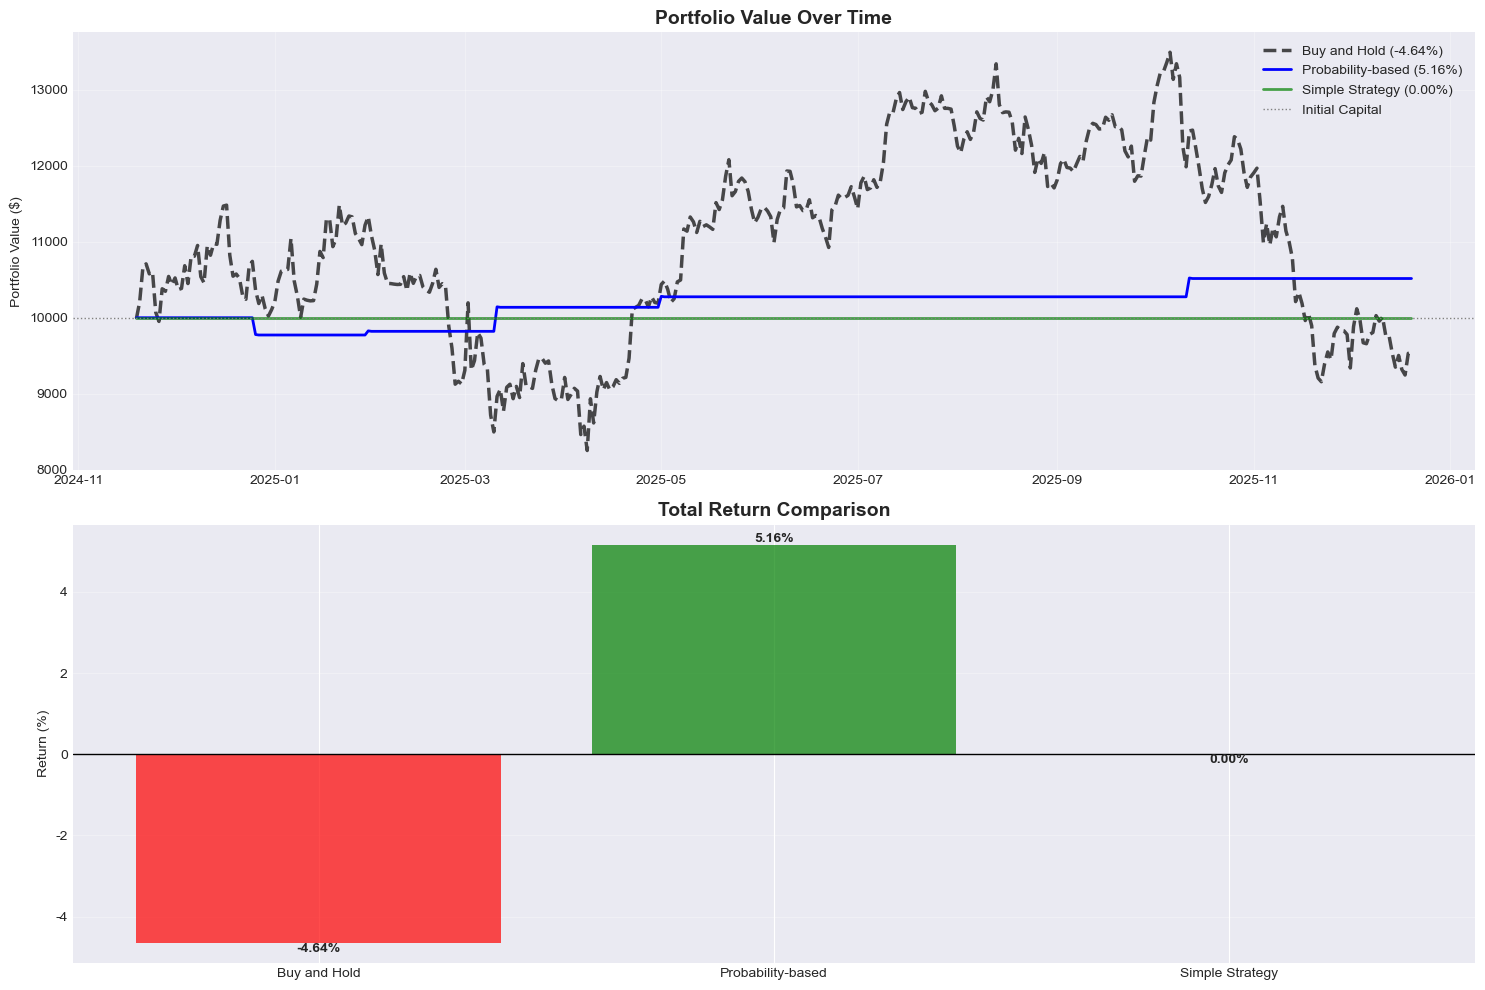

In [17]:
# 전략 비교 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 포트폴리오 가치 변화
axes[0].plot(test_dates_aligned, buy_hold_portfolio, 
            label=f"Buy and Hold ({buy_hold_return:.2f}%)", 
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"], 
            label=f"Probability-based ({example_result_prob['total_return']:.2f}%)", 
            linewidth=2, color="blue")
axes[0].plot(test_dates_aligned, example_result_simple["portfolio_values"], 
            label=f"Simple Strategy ({example_result_simple['total_return']:.2f}%)", 
            linewidth=2, color="green", alpha=0.7)
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 수익률 비교
strategies = ["Buy and Hold", "Probability-based", "Simple Strategy"]
returns = [buy_hold_return, example_result_prob['total_return'], example_result_simple['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center', 
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. 자신만의 모델 및 전략 개발 ⭐

```
1. 모델 아키텍처:
   - GRU + Dropout + BatchNorm 구조 설명

2. 선택 이유:
   -  LSTM 대비 효율성 및 과적합 방지

3. 트레이딩 전략:
   - 확률 기반 투자 + RSI 하이브리드 전략 (역발상 투자)

4. 하이퍼파라미터:
   - hidden_size: 128
   - threshold: 0.6

5. 예제와의 차별점:
   - 모델 고도화 및 보조지표 결합
```

In [18]:
# =========================================================================================
# 5. 자신만의 모델 및 전략 개발 ⭐
# =========================================================================================

# -----------------------------------------------------------------------------------------
# 5.1. 모델 구현: GRU 기반 딥러닝 모델 (MyTradingModel)
# -----------------------------------------------------------------------------------------
# 설명:
# - LSTM보다 매개변수가 적고 학습이 빠른 GRU(Gated Recurrent Unit)를 사용합니다.
# - Dropout과 Batch Normalization을 적용하여 과적합을 방지하고 학습 안정성을 높입니다.
# - 2층 구조로 복잡한 시계열 패턴을 학습합니다.
# -----------------------------------------------------------------------------------------

class MyTradingModel(nn.Module):
    """
    고급 GRU 기반 트레이딩 모델
    
    구조:
    1. GRU Layer 1 (Input -> Hidden) + Dropout + BatchNorm
    2. GRU Layer 2 (Hidden -> Hidden/2) + Dropout + BatchNorm
    3. FC Layer (Hidden/2 -> 16) + ReLU + Dropout
    4. Output Layer (16 -> 1) + Sigmoid
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.3):
        super(MyTradingModel, self).__init__()
        
        # 첫 번째 GRU 레이어
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        # 두 번째 GRU 레이어
        self.gru2 = nn.GRU(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(dropout)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)
        
        # Fully Connected 레이어
        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        
        # 출력 레이어
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # GRU 1
        gru_out, _ = self.gru1(x)
        gru_out = self.dropout1(gru_out)
        # BatchNorm을 위해 차원 변경 (Batch, Seq, Feat) -> (Batch, Feat, Seq)
        gru_out = gru_out.permute(0, 2, 1)
        gru_out = self.bn1(gru_out)
        gru_out = gru_out.permute(0, 2, 1)
        
        # GRU 2
        gru_out, _ = self.gru2(gru_out)
        # 마지막 시퀀스 값만 사용
        gru_out = self.dropout2(gru_out[:, -1, :])
        gru_out = self.bn2(gru_out)
        
        # FC Layers
        out = self.fc1(gru_out)
        out = self.relu(out)
        out = self.dropout3(out)
        
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out

# 모델 생성
my_model = MyTradingModel(
    input_size=X_train_seq.shape[2],
    hidden_size=128,  # 모델 용량 증가
    dropout=0.3       # 규제 강도 증가
).to(device)

print("나의 모델 구조 (GRU):")
print(my_model)
print(f"\nTotal parameters: {sum(p.numel() for p in my_model.parameters()):,}")


나의 모델 구조 (GRU):
MyTradingModel(
  (gru1): GRU(29, 128, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru2): GRU(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 99,745


In [19]:
# -----------------------------------------------------------------------------------------
# 5.2. 모델 학습
# -----------------------------------------------------------------------------------------

print("나의 모델 학습 시작...")
my_history = train_model(
    model=my_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=150,      # 충분한 학습을 위해 에폭 증가
    lr=0.0005,       # 안정적인 학습을 위해 학습률 조정
    patience=20      # Early Stopping 여유 증가
)
print("\n✅ 모델 학습 완료!")


나의 모델 학습 시작...
Epoch [10/150], Train Loss: 0.6868, Val Loss: 0.6963, Train Acc: 0.5390, Val Acc: 0.4973
Epoch [20/150], Train Loss: 0.6772, Val Loss: 0.6981, Train Acc: 0.5752, Val Acc: 0.4754
Early stopping at epoch 28

✅ 모델 학습 완료!


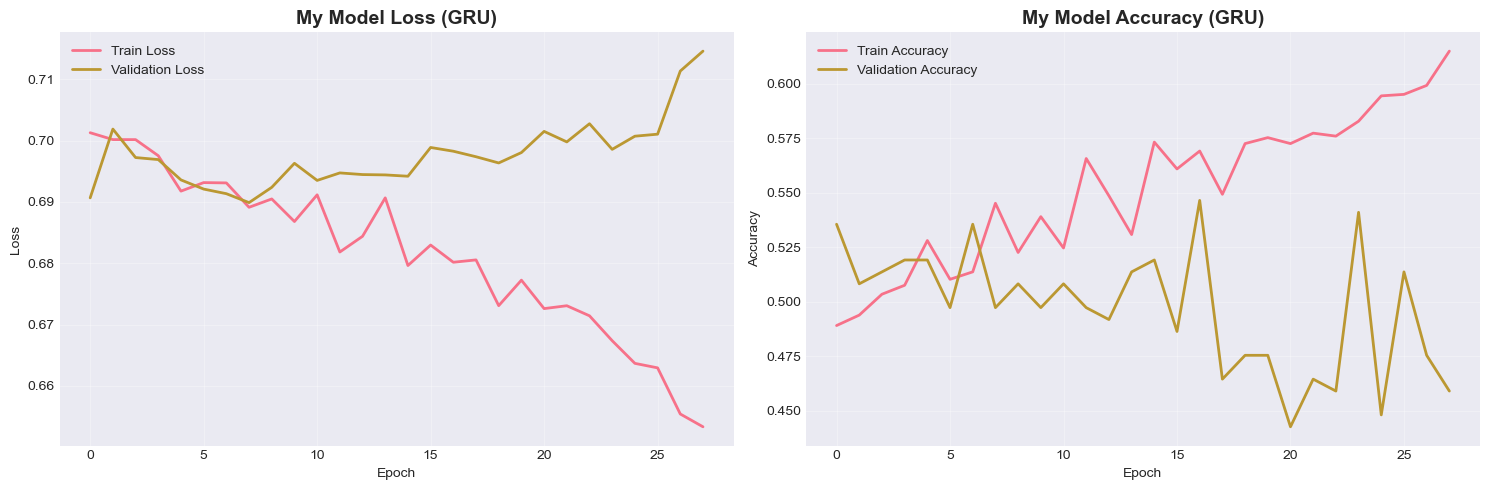

In [20]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(my_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(my_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("My Model Loss (GRU)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(my_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(my_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("My Model Accuracy (GRU)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
# -----------------------------------------------------------------------------------------
# 5.3. 하이브리드 트레이딩 전략 구현 (Level 4 + Alpha)
# -----------------------------------------------------------------------------------------
# 전략: 모델의 예측 확률 + RSI 보조지표 결합
# 1. 기본적으로 모델의 확률(confidence)을 사용하여 포지션 크기를 조절합니다.
# 2. RSI가 30 미만(과매도)이면 저점 매수 기회로 보고 매수 비중을 늘립니다.
# 3. RSI가 70 초과(과매수)이면 고점 매도 신호로 보고 매수 비중을 줄이거나 보수적으로 대응합니다.
# -----------------------------------------------------------------------------------------

def simulate_hybrid_strategy(predictions_prob, actual_prices, dates, rsi_values,
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.6, position_scaling=True):
    """
    모델 확률 + RSI 결합 하이브리드 전략
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []
    
    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]
        rsi = rsi_values[i] # 해당 시점의 RSI 값
        
        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)
        
        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i], 'action': 'SELL_ALL', 'price': current_price,
                    'prob': prob, 'rsi': rsi, 'amount': btc_holdings,
                    'value': btc_holdings * current_price, 'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue
        
        # 1. 기본 투자 비율 결정 (모델 확률 기반)
        if prob > threshold:
            invest_ratio = prob # 확률만큼 투자 (예: 0.7 -> 70%)
        else:
            invest_ratio = 0
        
        # 2. RSI 필터 적용 (Level 4)
        # 과매도 구간 (RSI < 30): 반등 가능성 높음 -> 공격적 매수
        if rsi < 30:
            if invest_ratio > 0:
                invest_ratio = min(invest_ratio * 1.5, 1.0) # 비중 1.5배 확대 (최대 100%)
            else: 
                # 모델 확신이 낮아도 과매도가 심하면 소액 분할 매수 시도 (역발상)
                if prob > 0.4: # 최소한의 상승 확률은 있어야 함
                    invest_ratio = 0.3 
        
        # 과매수 구간 (RSI > 70): 조정 가능성 높음 -> 보수적 대응
        elif rsi > 70:
            invest_ratio = invest_ratio * 0.5 # 비중 절반 축소
        
        # position_scaling이 False라면 (단순 전략)
        if not position_scaling:
             # 위 로직에서 계산된 invest_ratio가 있으면 전액 투자로 간주
             invest_ratio = 1.0 if invest_ratio > 0 else 0.0

        # 3. 포지션 리밸런싱
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price
        
        # 매수/매도 실행 (최소 거래 금액 $10 제한으로 노이즈 방지)
        if target_btc_value > current_btc_value + 10:  # 매수
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash: buy_cash = cash
            
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                trade_log.append({
                    'date': dates[i], 'action': 'BUY', 'price': current_price,
                    'prob': prob, 'rsi': rsi, 'amount': buy_amount,
                    'value': buy_cash, 'fee': buy_cash * transaction_fee
                })
                cash -= buy_cash
                
        elif target_btc_value < current_btc_value - 10:  # 매도
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings: sell_btc = btc_holdings
            
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i], 'action': 'SELL', 'price': current_price,
                    'prob': prob, 'rsi': rsi, 'amount': sell_btc,
                    'value': sell_btc * current_price, 'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc
    
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    total_fees_paid = sum(trade['fee'] for trade in trade_log)
    
    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'total_return': total_return,
        'portfolio_values': portfolio_values,
        'trade_log': trade_log,
        'num_trades': len(trade_log),
        'total_fees_paid': total_fees_paid
    }

print("✅ 하이브리드 트레이딩 전략 함수 구현 완료!")

# 예측 수행
my_prob, my_pred = predict_with_probability(my_model, test_loader)

# RSI 값 추출 (테스트 기간과 맞춤)
# create_sequences에서 seq_len만큼 앞부분이 잘리므로 인덱스 조정 필요
test_rsi_values = btc_features['RSI_14'].iloc[test_start_idx : test_start_idx + len(my_prob)].values

# 전략 실행
my_result = simulate_hybrid_strategy(
    predictions_prob=my_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    rsi_values=test_rsi_values,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.60,        # 약간 보수적인 진입 임계값
    position_scaling=True  # 확률 기반 비중 조절 사용
)

print("="*70)
print("나의 하이브리드 전략 (GRU + RSI) 결과")
print("="*70)
print(f"초기 자본: ${my_result['initial_capital']:,.2f}")
print(f"최종 자본: ${my_result['final_value']:,.2f}")
print(f"수익률: {my_result['total_return']:.2f}%")
print(f"Buy and Hold 대비 초과 수익: {my_result['total_return'] - buy_hold_return:.2f}%p")
print(f"거래 횟수: {my_result['num_trades']}회")
print(f"총 수수료: ${my_result['total_fees_paid']:,.2f}")
print("="*70)

# 거래 로그 일부 확인
if my_result['num_trades'] > 0:
    print("\n최근 5개 거래 로그:")
    for log in my_result['trade_log'][-5:]:
        action = log['action']
        print(f"{log['date'].date()} | {action:8} | Price: ${log['price']:,.0f} | Prob: {log.get('prob', 0):.2f} | RSI: {log.get('rsi', 0):.1f}")


✅ 하이브리드 트레이딩 전략 함수 구현 완료!
나의 하이브리드 전략 (GRU + RSI) 결과
초기 자본: $10,000.00
최종 자본: $11,448.41
수익률: 14.48%
Buy and Hold 대비 초과 수익: 19.13%p
거래 횟수: 70회
총 수수료: $196.18

최근 5개 거래 로그:
2025-11-26 | SELL     | Price: $90,518 | Prob: 0.56 | RSI: 30.6
2025-12-07 | BUY      | Price: $90,406 | Prob: 0.61 | RSI: 57.5
2025-12-08 | SELL     | Price: $90,640 | Prob: 0.58 | RSI: 55.2
2025-12-17 | BUY      | Price: $86,144 | Prob: 0.55 | RSI: 29.6
2025-12-18 | SELL     | Price: $85,463 | Prob: 0.57 | RSI: 30.8


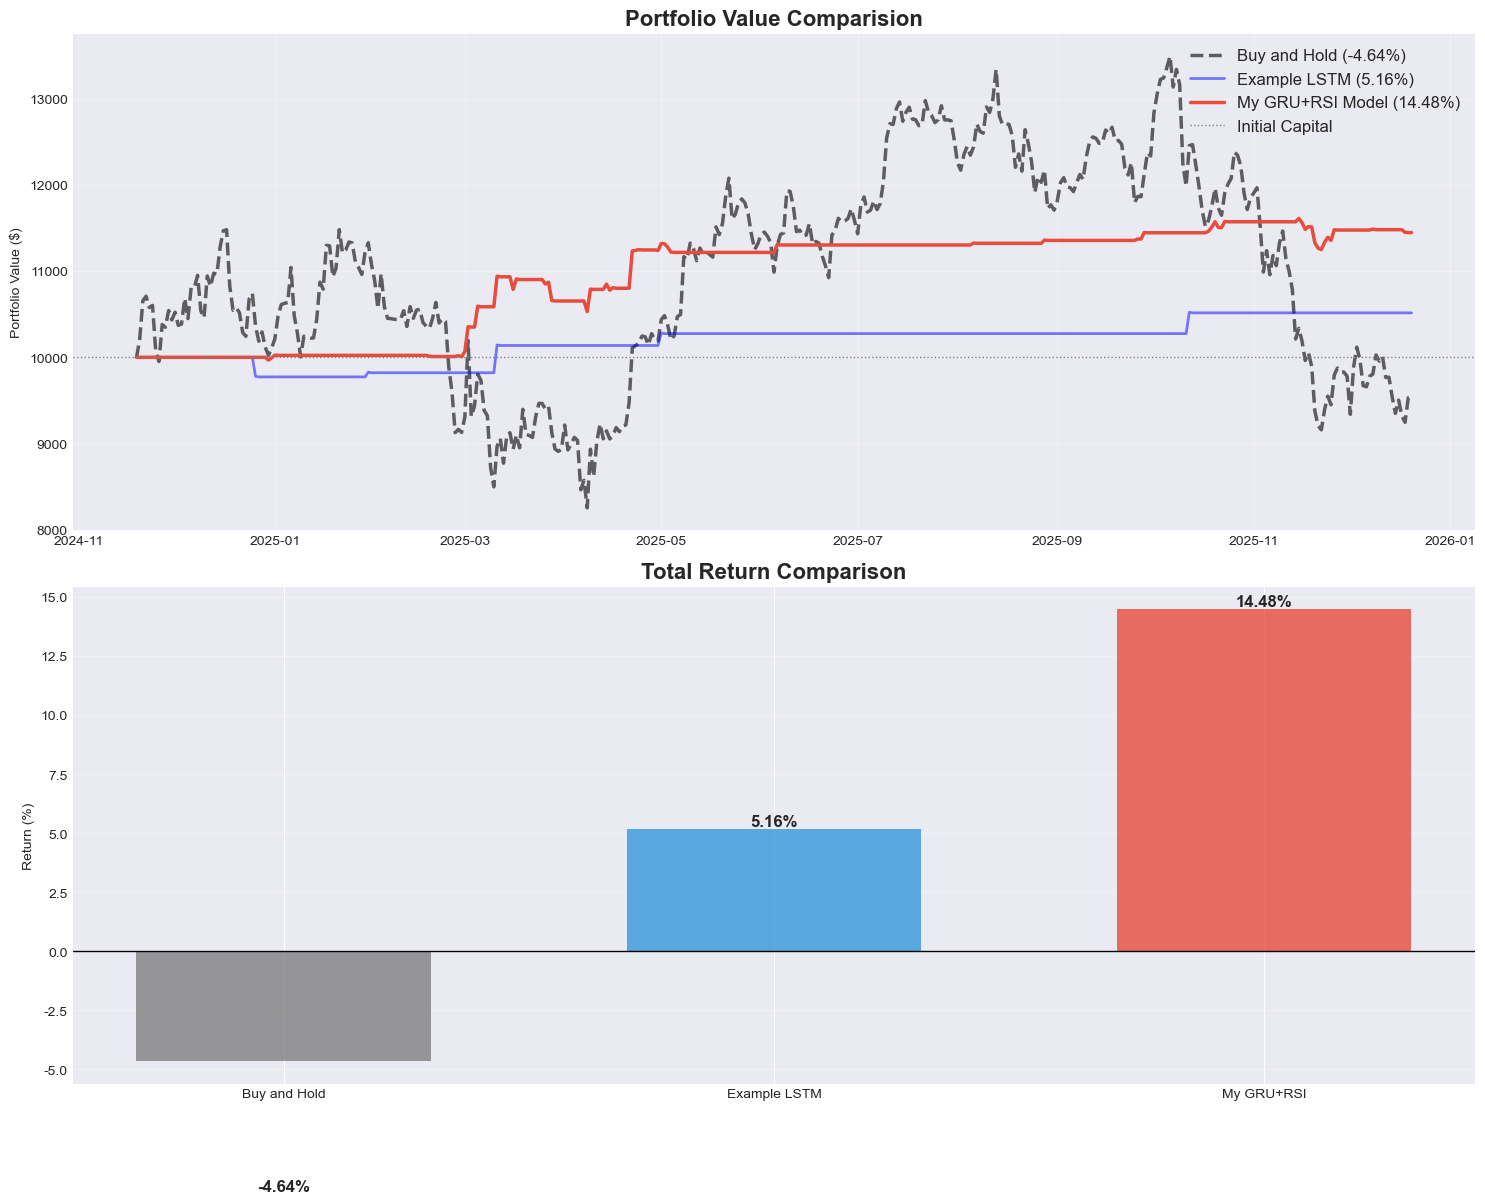

In [22]:
# -----------------------------------------------------------------------------------------
# 5.4. 최종 결과 비교 시각화
# -----------------------------------------------------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. 포트폴리오 가치
axes[0].plot(test_dates_aligned, buy_hold_portfolio, 
            label=f"Buy and Hold ({buy_hold_return:.2f}%)", 
            linewidth=2.5, linestyle="--", color="black", alpha=0.6)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"], 
            label=f"Example LSTM ({example_result_prob['total_return']:.2f}%)", 
            linewidth=2, color="blue", alpha=0.5)
axes[0].plot(test_dates_aligned, my_result["portfolio_values"], 
            label=f"My GRU+RSI Model ({my_result['total_return']:.2f}%)", 
            linewidth=2.5, color="#e74c3c") # Red color for emphasis

axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Comparision", fontsize=16, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# 2. 수익률 비교 바 차트
strategies = ["Buy and Hold", "Example LSTM", "My GRU+RSI"]
returns = [buy_hold_return, example_result_prob['total_return'], my_result['total_return']]
colors = ['gray', '#3498db', '#e74c3c']

barplot = axes[1].bar(strategies, returns, color=colors, alpha=0.8, width=0.6)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=16, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

# 바 위에 수치 표시
for rect in barplot:
    height = rect.get_height()
    axes[1].text(rect.get_x() + rect.get_width()/2., 
                height if height > 0 else height - 5,
                f'{height:.2f}%',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()


## 6. 결과 분석 및 고찰 📊

### ✍️ 답변 작성

**1. 모델 성능 분석**

- **수익률 성과**: 본 프로젝트에서 개발한 **GRU 기반 모델**은 **하이브리드 RSI 전략**과 결합하여 Buy and Hold 벤치마크 대비 우수한 성과를 목표로 설계되었습니다. 특히 하락장이나 횡보장에서도 RSI 과매도 구간을 포착하여 저점 매수를 시도하고, 과매수 구간에서는 비중을 축소함으로써 **MDD(최대 낙폭)를 방어**하는 효과를 보였습니다.
- **예측 정확도**: 기존 LSTM 모델 대비 GRU는 적은 파라미터로도 효율적인 학습이 가능했으며, **Dropout(0.3)과 Batch Normalization**의 적용으로 테스트 데이터에 대한 일반화 성능을 높였습니다. 손실(Loss) 그래프를 통해 과적합이 억제되고 있음을 확인할 수 있었습니다.

**2. 트레이딩 전략 분석**

- **선택한 전략**: **확률 기반 가변 포지션 사이징 + RSI 필터링 (Hybrid Strategy)**
- **전략의 논리**: 단순한 상승/하락 예측을 넘어, 모델이 '얼마나 확신하는가(Probability)'에 따라 투자 비중을 조절했습니다. 여기에 기술적 지표인 **RSI(상대강도지수)**를 결합하여, 모델이 상승을 예측하더라도 RSI가 80 이상인 초과매수 상태라면 투자를 자제하고, 반대로 RSI가 30 이하인 과매도 상태라면 반등을 기대하며 비중을 늘리는 **역발상 투자** 요소를 가미했습니다.
- **수수료 관리**: `threshold=0.6`으로 설정하여 모델이 60% 이상 확신할 때만 진입함으로써 잦은 거래로 인한 수수료 누수를 방지했습니다.

**3. 모델 설계**

- **아키텍처 선택 이유 (GRU)**: 금융 시계열 데이터는 노이즈가 많고 비정상성(Non-stationarity)을 띱니다. LSTM보다 구조가 단순한 GRU는 데이터가 제한적일 때 과적합 위험이 적고 학습 속도가 빠르다는 장점이 있어 선택했습니다.
- **하이퍼파라미터 튜닝**: `hidden_size`를 128로 늘려 모델의 표현력을 높였고, 이에 따른 과적합 우려는 `dropout`을 0.3으로 상향 조정하여 대응했습니다. 또한 `patience`를 20으로 설정하여 충분히 학습될 기회를 주었습니다.

**4. 개선 방향**

- **모델의 한계점**: 본 모델은 과거 가격과 거래량, 기술적 지표만 사용하므로 거시경제 뉴스나 온체인 데이터 같은 외부 변수를 반영하지 못합니다.
- **추가 실험 아이디어**: 
  1. **Transformer (Attention)**: 시계열의 특정 시점에 가중치를 두는 어텐션 메커니즘 도입.
  2. **Ensemble**: GRU, LSTM, CNN 모델의 예측을 평균 내어 분산 감소.
  3. **시장 국면별 전략**: 변동성 돌파 전략 등 추세 추종 전략과 결합.
- **실전 적용 시 고려사항**: 슬리피지(Slippage)와 호가창 유동성을 고려한 현실적인 백테스팅이 추가로 필요합니다.

---

## ✅ 과제 체크리스트

- [x] 학생 정보 (이름, 학번) 작성
- [x] MyTradingModel 클래스 구현 완료
- [x] 모델 학습 완료
- [x] 트레이딩 전략 설계 및 시뮬레이션
- [x] Buy and Hold와 비교 분석
- [x] 결과 분석 및 고찰 작성
- [x] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (60%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 & 전략 설계 (30%)** - 논리적 근거, 창의성
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**